# Lab4.2 Testing and evaluating an emotion text classifier

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Researchers create separate train, development (dev) and test splits for their data. This allows them to experiment with the training data by testing on the development set without optimizing on the test set. The final performance is reported on the test set. Other researchers can follow the same procedure and their test results can be compared because they are on the same unseen test set.

In the former notebook, we analysed the training and test data. In the notebook **Lab3.2.train-emotion-detection-bow.ipynb** of Lab3, we trained an SVM classifier with the MELD training data. In this notebook, we will load the model again and test and evaluate the performance on a test set that was not used during training. We will do the following:

1. We load countvectorizer, tf.idf transformer and the SVM classifier from disk
2. Represent the test data according to the countvectorizer, tf.idf transformer
3. We get the predictions of the classifier on the test set
4. Evaluate the performance on the test set against the gold labels
5. Analyse possible confusion of the model across the categories


## 1. Loading the trained classifier

In [9]:
import pickle
# the countvectorizer
filename_vectorizer = '../lab3.machine_learning/models/utterance_vectorizer.sav'
# the tfidf transformer
filename_tfidftransformer = '../lab3.machine_learning/models/utterance_tfidf_transformer.sav'
# the classifier to disk
filename_classifier = '../lab3.machine_learning/models/svm_linear_clf_bow.sav'

# load the classifier and the vectorizer from disk
loaded_classifier = pickle.load(open(filename_classifier, 'rb'))
loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))
loaded_tfidftransformer = pickle.load(open(filename_tfidftransformer, 'rb'))

## 2. Representing the test text as numerical vectors <a class="anchor" id ="section4.2"></a> 

We first load the test data from the ```Lab3.machine_learning/data/MELDtest_sent_emo.csv``` in Pandas.

In [7]:
import pandas as pd
filepath = '../Lab3.machine_learning/data/MELD/test_sent_emo.csv'
# Create a dataframe object 'dtest' by readig the file.
dftest = pd.read_csv(filepath)
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


From the dataframe, we can pull out the column ```Utterance``` and ```Emotion``` columns to get the test texts and the test labels. We will compare the prediction of the model against the test labels which act as the gold labels.

In [8]:
test_instances=dftest['Utterance']
test_labels = dftest['Emotion']

The representation of the test data needs to be compatible with the training data. To ensure this we use the vectorizer created from the training data to also represent the test data.

Instead of *fit_transform*, we need to use the function *transform* from ```loaded_vectorizer```. The *transform* function will represent the text according to the vector model of the training data and ignore all out-of-vocabulary words in the test texts. 

In [10]:
test_count_vectors = loaded_vectorizer.transform(test_instances)
print(test_count_vectors.shape)
print(test_instances[0])
print(test_count_vectors.toarray()[0][:50])

/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


(2610, 1103)
Why do all you're coffee mugs have numbers on the bottom?
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that the test data has vectors of the same length as the training data vectors of  Lab3.2.train-emotion-detection-bow.ipynb: 1103 dimensions. The vectors have many zeros and a few positions scored with one. There are as many vectors as test utterances: 2610.

We can use the same ```loaded_tfidftransformer``` to turn the count vectors into weighted vectors:

In [11]:
test_tfidf_vectors = loaded_tfidftransformer.transform(test_count_vectors)

In [12]:
print(test_tfidf_vectors.toarray()[0][:50])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.48498825 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.28648314 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


# 3. Getting the classifier predictions and evaluate the results

We can now apply the classifier to the test data to get the predictions.

In [13]:
# Predicting the Test set results, find macro recall
y_pred_svm = loaded_classifier.predict(test_tfidf_vectors)
print('First ten predictions from the SVM classifier', y_pred_svm[0:10])

First ten predictions from the SVM classifier ['neutral' 'neutral' 'neutral' 'neutral' 'joy' 'neutral' 'neutral'
 'neutral' 'neutral' 'joy']


Sklearn provides functions to obtain the **recall**, **precision** and **f-score** for all the test set results. We can simply pass the human "gold" labels and the system "predicted" labels as input and set a parameter how to aggregate the overall score. The ```classification_report``` function gives the complete result:

In [14]:
from sklearn.metrics import classification_report
report = classification_report(test_labels,y_pred_svm,digits = 3, target_names = loaded_classifier.classes_)
print('BoW TFIDF SVM LINEAR ----------------------------------------------------------------')

print(report)

BoW TFIDF SVM LINEAR ----------------------------------------------------------------
              precision    recall  f1-score   support

       anger      0.433     0.188     0.263       345
     disgust      0.200     0.029     0.051        68
        fear      0.167     0.020     0.036        50
         joy      0.437     0.465     0.451       402
     neutral      0.640     0.860     0.734      1256
     sadness      0.339     0.096     0.150       208
    surprise      0.487     0.466     0.476       281

    accuracy                          0.569      2610
   macro avg      0.386     0.304     0.309      2610
weighted avg      0.520     0.569     0.522      2610



In the classification report we see the precision, recall and f1-score for each label and averaged scores: accuracy, macro avg and weighted (or micro) average. Also note the support column that indicates how many test cases there are in each category and in total. There are a lot more test cases with `neutral` than for the other emotions.

We can see that the performance varies a lot across the emotions. The results for `neutral` are a lot better in precision and recall than the other emotions: `joy` and `surprise` have reasonable scores but the others have very low recall and `disgust` and `fear` also low precision. Overall macro average f1-score is 0.3 which is lower than the majority baseline of 0.48 when always choosing `neutral`. The weighted f1-score, in which the proportion of test cases per catgory is used to weigh the results, is just above the baseline. The higher support for neutral means it dominates both in the training data and in the test. If we would create a more-balanced test set, the macro-average score is expected to be a lot lower. Can you explain why?

Ideally, recall and precision are balanced but if they deviate it is worth thinking about the causes. Some possible causes for unbalanced or poor results are:

* Not enough training data to capture all variation in the test data
* Biased training data that makes one category stronger than the other(s)
* Too much ambiguity so that words (as features) get different interpretations in different contexts
* Over-fitting to the training data so that it learns features that do not generalise to the test data
  
During this master programme, you will work with many different data sets and analyse the performance of classifiers. Analysing different data, experimenting with text representations and machine learning algorithms is the best way to learn about possible causes and how to mitigate them. We already analysed the data proeprties in the previous notebook. Can you think of explanations for the performance based on the analysis of the data?

To get more insight in how well the classifier can distinguish the different class, Sklearn can also generate a so-called confusion matrix, which indicates which classes are confused with which other classes (false positives). For this we use the function ```metrics.confusion_matrix```. We visualise it using ```ConfusionMatrixDisplay``` that we need to import separately.

Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[  65    2    0   78  162    3   35]
 [   5    2    1    8   42    2    8]
 [   4    1    1    9   25    4    6]
 [  20    2    2  187  156    5   30]
 [  27    3    2   74 1080   20   50]
 [  16    0    0   27  136   20    9]
 [  13    0    0   45   87    5  131]]


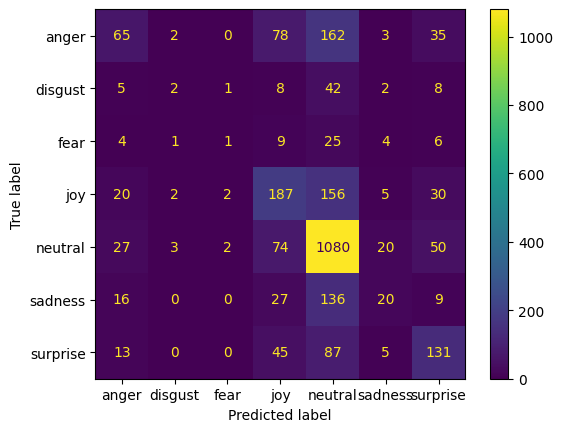

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion matrix SVM')
print(loaded_classifier.classes_)
cf_matrix_svm = confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=loaded_classifier.classes_)
display.plot()

The diagonals represent the correctly classified test utterances. All others indicate the confusions, where another class was wrongly assigned (columns) or not assigned (rows). It is clear that the neutral column has most results not only for the **True** label (1080) but also the other rows in the Predicted column: 162, 42, 25, 156, 136, 87. Besides the dominance of `neutral`, we see that `anger` spills a bit into `joy`, `sadness` and `neutral` and `joy` into `anger`, `neutral` and `surprise`. Furthermore, note that `surprise` is confused with both `anger` and `joy`. This makes sense because you can be surprised in a positive and negative way. Think a minute how the sentiment labels in MELD may help here. How would you fix the last confusion?


Our system performs just above the baseline of the dominant class *neutral*: .47 (see previous notebook on the data analysis). What can you do if one class is so dominant?
The next notebook Lab4.4 describes a number of different approach to adjust the classifier.

# End of this notebook